<a href="https://colab.research.google.com/github/mellisairawan/OrbitFutureAcademy2/blob/main/Time_Series_dengan_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modul Standar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Import Data
Import data Konsumsi Energi dari American Electric Power (AEP):
https://raw.githubusercontent.com/khsieh18/Time-Series/master/AEP_hourly.csv


In [ ]:
# Import data dan lihat 10 kolom teratas
df = pd.read_csv('https://raw.githubusercontent.com/khsieh18/Time-Series/master/AEP_hourly.csv')
df.head(10)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


In [ ]:
# Informasi singkat dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


# Pre-process Data
Dari informasi diatas, dapat diketahui bahwa dataframe terdiri dari 121,273 baris. Selain itu "Datetime" masih berupa object(string) sehingga perlu diubah menjadi tipe data ``datetime`'

In [ ]:
# Merubah tipe data object ke datetime
df["Datetime"] = df["Datetime"].astype('datetime64')
# Mengurutkan data berdasarkan waktu
df.sort_values('Datetime', inplace=True, ignore_index=True)
print(df.head())

             Datetime   AEP_MW
0 2004-10-01 01:00:00  12379.0
1 2004-10-01 02:00:00  11935.0
2 2004-10-01 03:00:00  11692.0
3 2004-10-01 04:00:00  11597.0
4 2004-10-01 05:00:00  11681.0


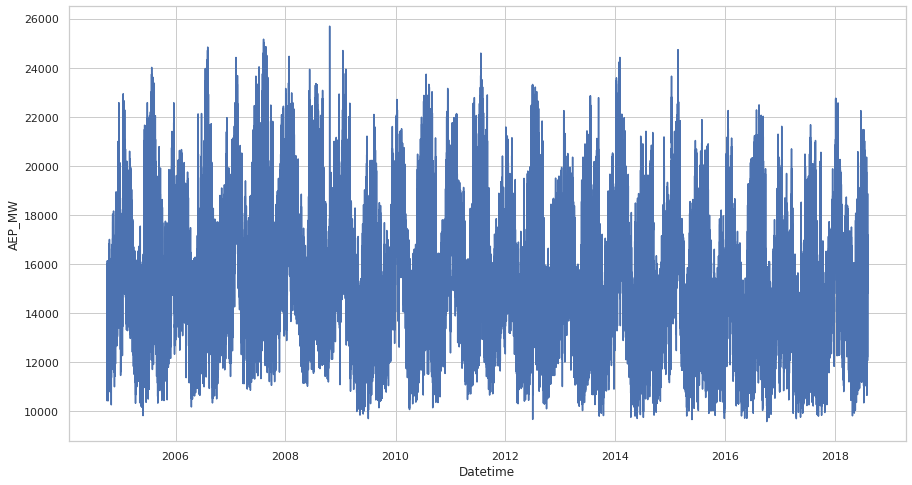

In [ ]:
# Plot dataframe
plt.figure(figsize=(15,8))
sns.lineplot(data=df, x='Datetime', y='AEP_MW')

Pada contoh ini hanya akan digunakan data setahun terakhir dari data AEP_hourly. Karena data yang diobservasi per jam, maka kita akan mengambil ``24 *3 65 = 8760`` baris terakhir.

In [ ]:
# Memilih data satu tahun terakhir
df1 = df[-24*365:].reset_index(drop=True) # Nilai negatif karena mengambil dari baris paling bawah
df1.head()

,Datetime,AEP_MW
0,2017-08-03 01:00:00,13682.0
1,2017-08-03 02:00:00,12841.0
2,2017-08-03 03:00:00,12443.0
3,2017-08-03 04:00:00,12213.0
4,2017-08-03 05:00:00,12286.0


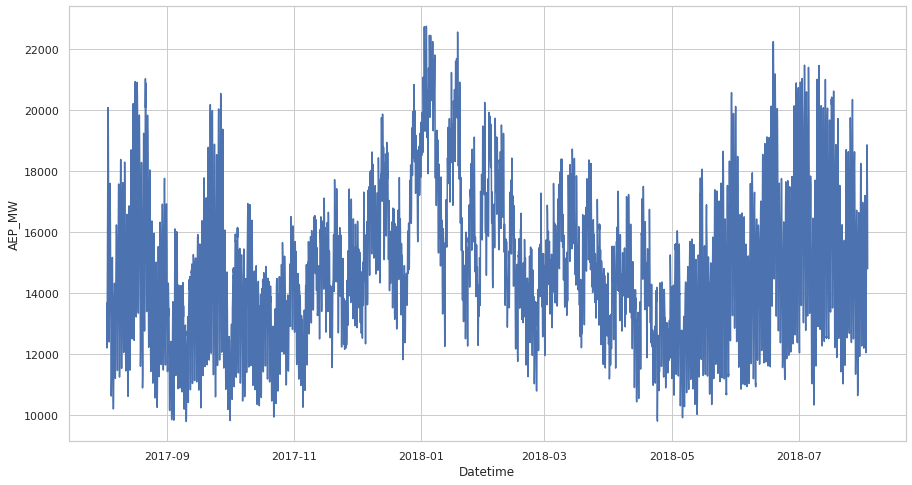

In [ ]:
# Plot dataframe yang baru
plt.figure(figsize=(15,8))
sns.lineplot(data=df1, x='Datetime', y='AEP_MW')

Sebelum melakukan pembuatan model, sebaiknya dilakukan analisa terhadap statistika deskriptif. Dari statistika deskriptif, dapat dilihat range dari data dan ukuran pusat data.

In [ ]:
# Statistika deskriptif
df1.describe()

,AEP_MW
count,8760.000000
mean,14963.130708
std,2438.848843
min,9801.000000
25%,13260.750000
50%,14721.500000
75%,16421.750000
max,22759.000000


Dari statistika deskriptif diatas, dapat terlihat bahwa data ``AERP_MW`` memiliki nilai yang cukup besar dan berada pada range 9,801 hingga 22,759. Dapat dilakukan feature scalling menggunakan MinMaxScaler agar range dari seluruh data tersebut berada di antara nilai 0 dan 1.

## Memisah (Split) Data
Split data dilakukan agar model yang telah dilatih dapat dievaluasi kemampuannya. Data yang digunakan adalah data ``time series``, maka split data tidak diakukan secara acak. Dapat dilakukan juga cross validation menggunakan data train. Pada contoh ini akan digunakan 70% baris pertama sebagai data train dan 30% sisanya sebagai data test.

In [ ]:
# Split Data
train_size = int(len(df1) * 0.7)
train = df1[:train_size]
test = df1[train_size:].reset_index(drop=True)

In [ ]:
# Feature Scalling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['AEP_MW']])

train['scaled'] = scaler.transform(train[['AEP_MW']])
test['scaled'] = scaler.transform(test[['AEP_MW']])

print(train.head())

             Datetime   AEP_MW    scaled
0 2017-08-03 01:00:00  13682.0  0.299506
1 2017-08-03 02:00:00  12841.0  0.234604
2 2017-08-03 03:00:00  12443.0  0.203889
3 2017-08-03 04:00:00  12213.0  0.186140
4 2017-08-03 05:00:00  12286.0  0.191773


# Membuat fungsi Sliding Window
Selanjutnya akan dibuat fungsi sliding window dengan input data (numpy array) dan window size.

In [ ]:
def sliding_window(data, window_size):
  sub_seq, next_values = [], []
  for i in range(len(data)-window_size):
    sub_seq.append(data[i:i+window_size])
    next_values.append(data[i+window_size])
  X = np.stack(sub_seq)
  y = np.array(next_values)
  return X, y

Berapa window size yang tepat untuk digunakan? <br>
Pada penerapannya kita dapat menentukan window size berapa saja. Untuk mencapai hasil yang maksimal dapat dilakukan percobaan dengan menggunakan beberapa window size. <br> <br>
Perlu diperhatikan bahwa **semakin besar window size** yang digunakan akan memerlukan waktu yang cukup lama dalam proses training data. Pada contoh ini kita hanya menggunakan window size = 24 atau sama dengan 1 hari dan kita terapkan pada data train dan test yang telah discaling.

In [ ]:
window_size = 24
X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)

**PENTING!!** <br>
Data input LSTM harus 3D: [samples, timesteps, feature]. Maka dari itu, kita perlu cek dimensi data menggunakan ``np.shape``

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6108, 24, 1) (6108, 1)
(2604, 24, 1) (2604, 1)


# LSTM menggunakan TensorFlow dan Keras
Untuk membuat LSTM() layer menggunakan Keras, perhatikan parameter-parameter berikut untuk membuat LSTM layer sederhana. <br><br>
Ada beberapa parameter yaitu..
- ``units``: menentukan banyaknya LSTM unit
- ``input shape``: menentukan ukuran timesteps dan feature, diperlukan pada layer pertama
- ``return_sequences``: jika layer berikutnya berupa LSTM layer maka retun_sequences = True (default = False)

Parameter lainnya dapat dilihat pada: https://keras.io/api/layers/recurrent_layers/lstm/


# Membuat Model Forecasting Menggunakan LSTM
Untuk menggunakan arsitektur GRU, ganti model LSTM dengan RNN atau GRU.

## Import Modul

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM #, RNN, GRU

## Membuat Fungsi Model Forecasting Menggunakan LSTM
Fungsi model yang akan dibuat terdiri:<br>
LSTM layer dengan 
* input_shape = (window_size, 1)
* Dense layer dengan 32 neuron dengan fungsi aktivasi ReLu
* Dropout antara Dense layer dan Dense output layer
* Dense output layer dengan 1 neuron
* loss function yang digunakan adalah Mean Squared Error (MSE)
* optimizer yang digunakan adalah adam
* metric yang digunakan adalah Mean Absolute Error (MAE)

* Parameter-parameter yang dijadikan sebagai input dari fungsi tersebut adalah:
  - LSTM_unit: banyaknya LSTM unit (default = 64)
  - dropout: persentase dropout (default = 0.2

In [ ]:
def create_model(LSTM_unit=64, dropout=0.2): # jika ingin menggunakan RNN atau GRU ganti LSTM dengan GRU/RNN
  # membuat model
  model = Sequential()
  model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  # compile
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

## 3. Membuat Model
Coba dilakukan hypertuning dengan parameter dengan mencoba kombinasi nilai ``LSTM unit``nya 16, 32, 64, 28 dan peluang ``dropout`` 0.1 dan 0.2

Selain itu, juga digunakan ``early stopping`` pada saat proses training

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)

# Create model
model = KerasRegressor(build_fn=create_model, 
                       epochs=50, 
                       validation_split=0.1, 
                       batch_size=32,
                       callbacks=[es],
                       verbose=1)

# define the grid search parameters
LSTM_unit = [16, 32, 64, 128]
dropout = [0.1, 0.2]
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

# 4. Membuat Variabel GridSearchCV
Variabel GridSearchCV dibuat dengan memasukan beberapa parameter yaitu:
- estimator: model yang ingin dilakukan gridsearch
- param_grid: parameter yang ingin diuji
- n_jobs: Jumlah pekerjaan untuk dijalankan secara paralel. (-1 artinya menggunakan seluruh core processor)
- cv: banyaknya k-fold cross validation

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

## 5. Training Model dengan GridSearchCV

In [ ]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
172/172 [==============================] - 7s 27ms/step - loss: 0.0147 - mae: 0.0889 - val_loss: 0.0037 - val_mae: 0.0475
Epoch 2/50
172/172 [==============================] - 4s 24ms/step - loss: 0.0053 - mae: 0.0563 - val_loss: 0.0018 - val_mae: 0.0329
Epoch 3/50
172/172 [==============================] - 4s 24ms/step - loss: 0.0035 - mae: 0.0450 - val_loss: 0.0014 - val_mae: 0.0310
Epoch 4/50
172/172 [==============================] - 4s 24ms/step - loss: 0.0030 - mae: 0.0412 - val_loss: 0.0010 - val_mae: 0.0237
Epoch 5/50
172/172 [==============================] - 4s 24ms/step - loss: 0.0025 - mae: 0.0378 - val_loss: 8.8115e-04 - val_mae: 0.0220
Epoch 6/50
172/172 [==============================] - 4s 24ms/step - loss: 0.0024 - mae: 0.0368 - val_loss: 7.9717e-04 - val_mae: 0.0211
Epoch 7/50
172/172 [==============================] - 4s 24ms/step - loss: 0.0023 - mae: 0.0357 - val_loss: 7.0455e-04 - val_mae: 0.0200
Epoch 8/50
172/172 [==============================] - 4s 

## 6. Melihat Hasil Parameter Terbaik

In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.000373 using {'LSTM_unit': 64, 'dropout': 0.1}
-0.000457 (0.000062) with: {'LSTM_unit': 16, 'dropout': 0.1}
-0.000507 (0.000137) with: {'LSTM_unit': 16, 'dropout': 0.2}
-0.000459 (0.000081) with: {'LSTM_unit': 32, 'dropout': 0.1}
-0.000440 (0.000088) with: {'LSTM_unit': 32, 'dropout': 0.2}
-0.000373 (0.000056) with: {'LSTM_unit': 64, 'dropout': 0.1}
-0.000405 (0.000040) with: {'LSTM_unit': 64, 'dropout': 0.2}
-0.000396 (0.000069) with: {'LSTM_unit': 128, 'dropout': 0.1}
-0.000400 (0.000091) with: {'LSTM_unit': 128, 'dropout': 0.2}


Dapat dilihat grafik loss function MSE dan metric MAE terhadap epoch untuk melihat performa model dengan cara sebagai berikut.

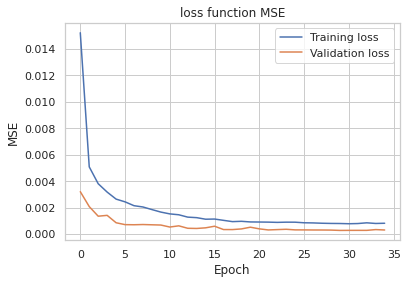

In [ ]:
history = best_model.history
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

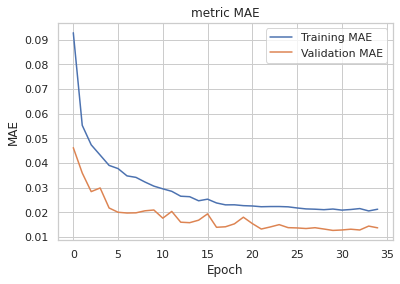

In [ ]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

## 7. Evaluasi Model

In [ ]:
# Prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(X_train))
true_train = scaler.inverse_transform(y_train)

# Prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(X_test))
true_test = scaler.inverse_transform(y_test)

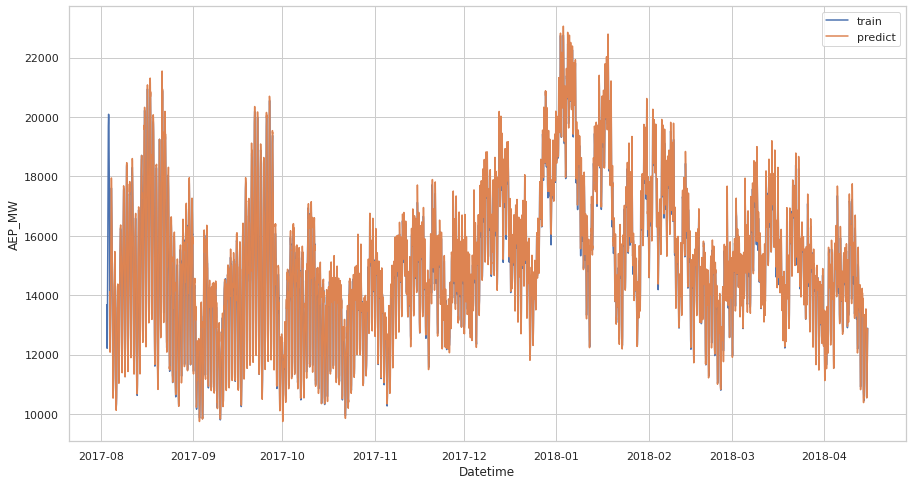

In [ ]:
# Plot Prediksi Data Train
train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='Datetime', y='AEP_MW', label = 'train')
sns.lineplot(data=train, x='Datetime', y='predict', label = 'predict')

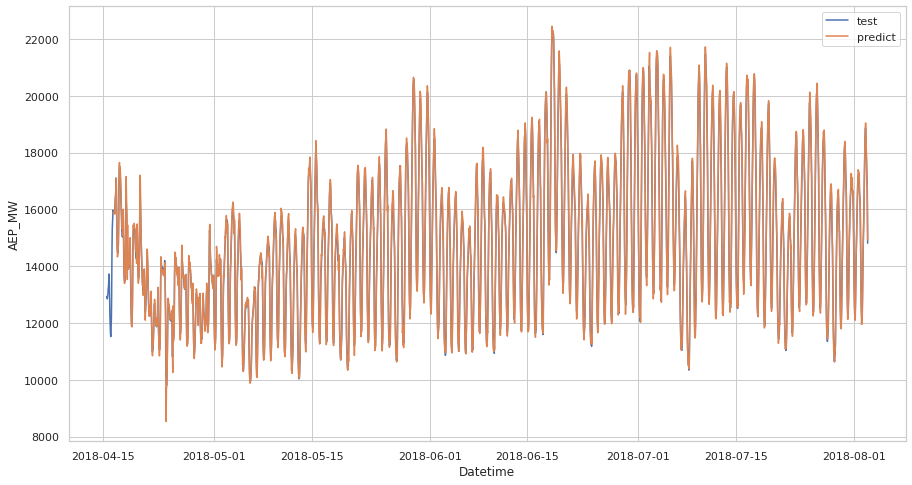

In [ ]:
# Plot Prediksi Data Test
test['predict'] = np.nan
test['predict'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='Datetime', y='AEP_MW', label = 'test')
sns.lineplot(data=test, x='Datetime', y='predict', label = 'predict')

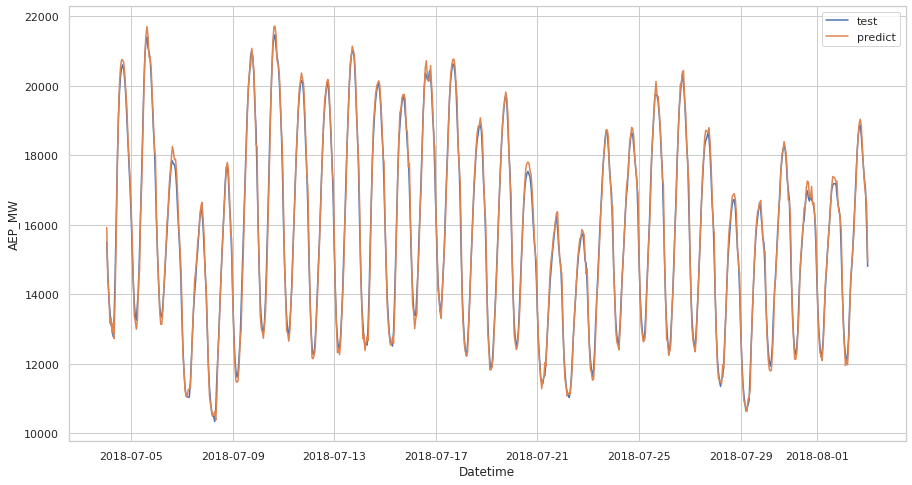

In [ ]:
# Plot Prediksi Data Test Sebulan Terakhir
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-24*30:], x='Datetime', y='AEP_MW', label = 'test')
sns.lineplot(data=test[-24*30:], x='Datetime', y='predict', label = 'predict')

### Forecasting

Text(0, 0.5, 'AEP_MW')

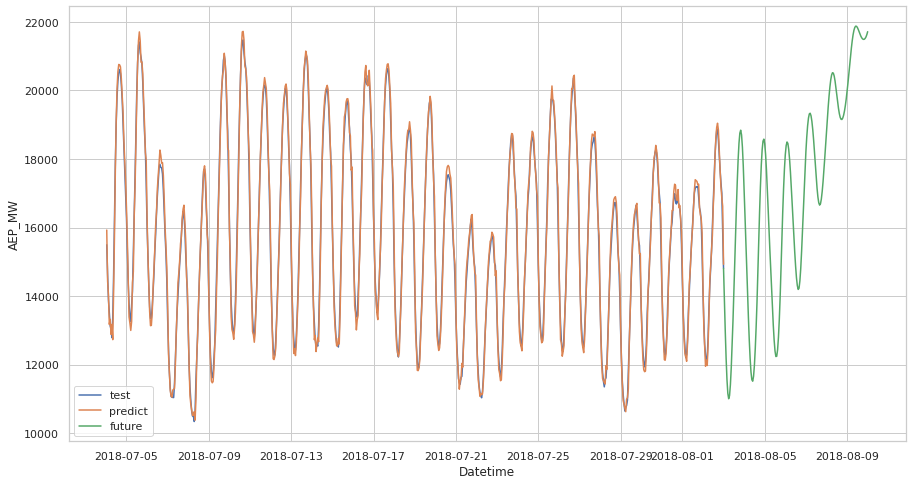

In [ ]:
# Forecasting data selanjutnya
y_test = scaler.transform(test[['AEP_MW']])
n_future = 24*7 # prediksi 7 hari berikutnya
future = [[y_test[-1,0]]]
X_new = y_test[-window_size:,0].tolist()

for i in range(n_future):
  y_future = best_model.predict(np.array([X_new]).reshape(1,window_size,1))
  future.append([y_future[0,0]])
  X_new = X_new[1:]
  X_new.append(y_future[0,0])

future = scaler.inverse_transform(np.array(future))
date_future = pd.date_range(start=test['Datetime'].values[-1], periods=n_future+1, freq='H')

# Plot Data sebulan terakhir dan seminggu ke depan
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-24*30:], x='Datetime', y='AEP_MW', label='test')
sns.lineplot(data=test[-24*30:], x='Datetime', y='predict', label='predict')
sns.lineplot(x=date_future, y=future[:,0], label='future')
plt.ylabel('AEP_MW')